### Importing necessary modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [3]:
import os
from tqdm import tqdm
import random
from itertools import chain

In [4]:
import cv2
from glob import glob

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model,save_model
from tensorflow.keras.layers import (Input, Activation,
                                     BatchNormalization, 
                                     Dropout, Lambda, Conv2D,
                                     Conv2DTranspose, MaxPooling2D,
                                     concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
from skimage import io
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler, normalize


In [8]:
os.listdir('../input/lgg-mri-segmentation/kaggle_3m/')

['TCGA_DU_7010_19860307',
 'TCGA_DU_8162_19961029',
 'TCGA_FG_A4MT_20020212',
 'TCGA_FG_5964_20010511',
 'TCGA_DU_A5TS_19970726',
 'TCGA_HT_7692_19960724',
 'TCGA_DU_5849_19950405',
 'TCGA_FG_A60K_20040224',
 'TCGA_HT_7475_19970918',
 'TCGA_FG_6691_20020405',
 'TCGA_HT_7684_19950816',
 'TCGA_CS_6188_20010812',
 'TCGA_HT_7694_19950404',
 'TCGA_DU_A5TR_19970726',
 'TCGA_DU_7300_19910814',
 'TCGA_DU_7018_19911220',
 'TCGA_DU_7301_19911112',
 'TCGA_DU_7302_19911203',
 'TCGA_HT_8018_19970411',
 'TCGA_FG_6692_20020606',
 'TCGA_DU_5854_19951104',
 'TCGA_DU_7299_19910417',
 'TCGA_HT_A5RC_19990831',
 'TCGA_HT_8105_19980826',
 'TCGA_HT_8563_19981209',
 'TCGA_HT_A61A_20000127',
 'TCGA_CS_4944_20010208',
 'TCGA_FG_7643_20021104',
 'TCGA_DU_8163_19961119',
 'TCGA_CS_6669_20020102',
 'TCGA_DU_7013_19860523',
 'TCGA_FG_8189_20030516',
 'TCGA_HT_8111_19980330',
 'TCGA_CS_5396_20010302',
 'TCGA_DU_7294_19890104',
 'TCGA_HT_7879_19981009',
 'README.md',
 'TCGA_EZ_7264_20010816',
 'TCGA_DU_8164_19970111'

In [9]:
root = '../input/lgg-mri-segmentation/kaggle_3m/'

In [10]:
WIDTH = HEIGHT = 256

In [11]:

# data containing path to Brain MRI and their corresponding mask
brain_df = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')


In [12]:
brain_df.info

<bound method DataFrame.info of           Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0    TCGA_CS_4941            2.0                 4.0             2        2.0   
1    TCGA_CS_4942            1.0                 5.0             2        1.0   
2    TCGA_CS_4943            1.0                 5.0             2        1.0   
3    TCGA_CS_4944            NaN                 5.0             2        1.0   
4    TCGA_CS_5393            4.0                 5.0             2        1.0   
..            ...            ...                 ...           ...        ...   
105  TCGA_HT_8563            2.0                 5.0             3        1.0   
106  TCGA_HT_A5RC            2.0                 4.0             2        2.0   
107  TCGA_HT_A616            NaN                 5.0             2        1.0   
108  TCGA_HT_A61A            NaN                 5.0             2        NaN   
109  TCGA_HT_A61B            NaN                 5.0             2        1.0

In [13]:
brain_df.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [14]:
data_map = []
for sub_dir_path in glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [15]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [16]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_11.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_11_mask.tif


In [17]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


In [18]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [19]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [20]:
# loading images
mask_files = glob(root +'*/*_mask*')
img_files = list(map(lambda x: x.replace('_mask',''),mask_files))


In [21]:
len(img_files)

3929

### Visualizing Images

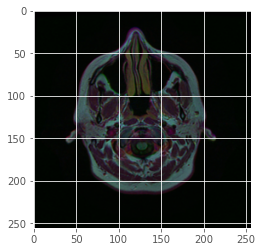

In [22]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

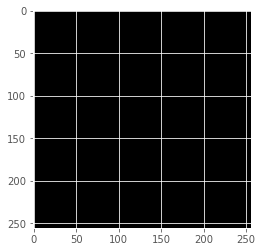

In [23]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

In [24]:
cv2.imread(brain_df.mask_path[623]).max()

0

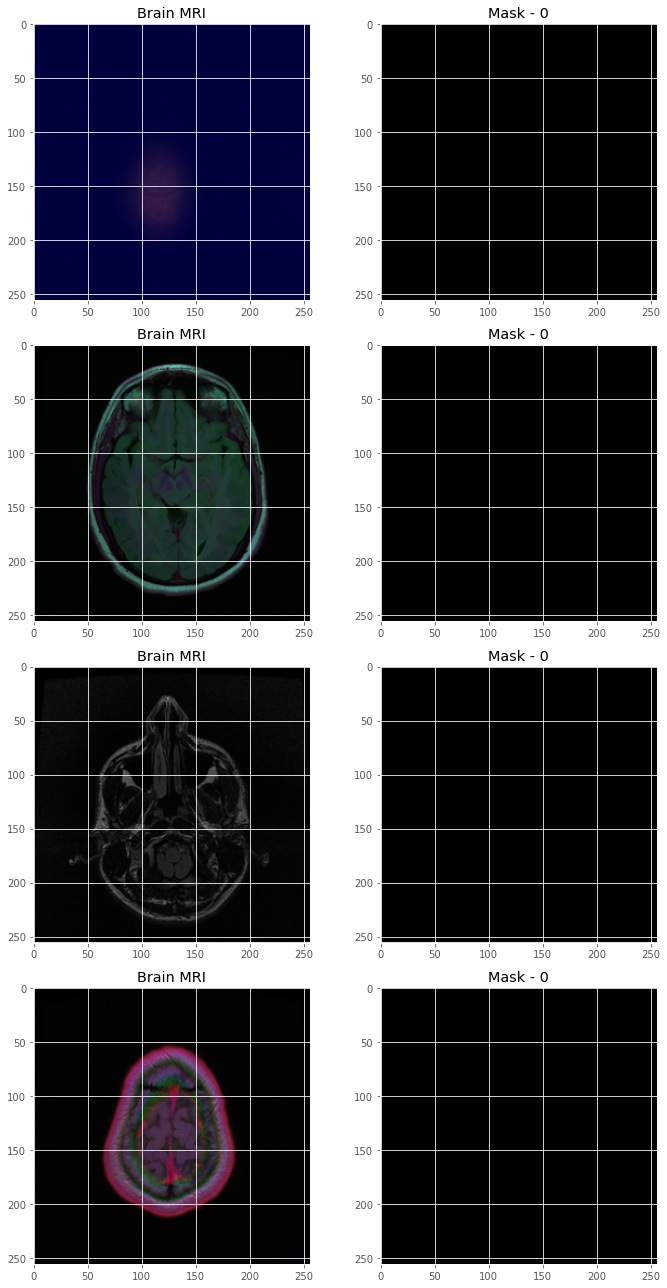

In [25]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 
import random
fig, axs = plt.subplots(4,2, figsize=(10,18))
count = 0
for x in range(4):
    i = random.randint(0, len(brain_df)) # select a random index
    axs[count][0].title.set_text("Brain MRI") # set title
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
    count += 1

fig.tight_layout()



In [26]:
# display random iteration of images from the dataset with their masks
#fig = plt.figure(figsize=(13, 13))
#rnd_no = np.random.randint(0,len(img_files)-9)
#for ind, i in enumerate(range(rnd_no, rnd_no+9)):
    
 #   fig.add_subplot(3,3,ind+1)
    
    # get image & mask file paths
  #  img_path = img_files[i]
   # msk_path = mask_files[i]
    
    # read images
    #img = cv2.imread(img_path)
    #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #msk = cv2.imread(msk_path)
    
    # display images
    #plt.imshow(img)
   # plt.imshow(msk, alpha=0.5)
    #plt.title(img_path.split('/')[-1].split('.')[0])#
#plt.show()

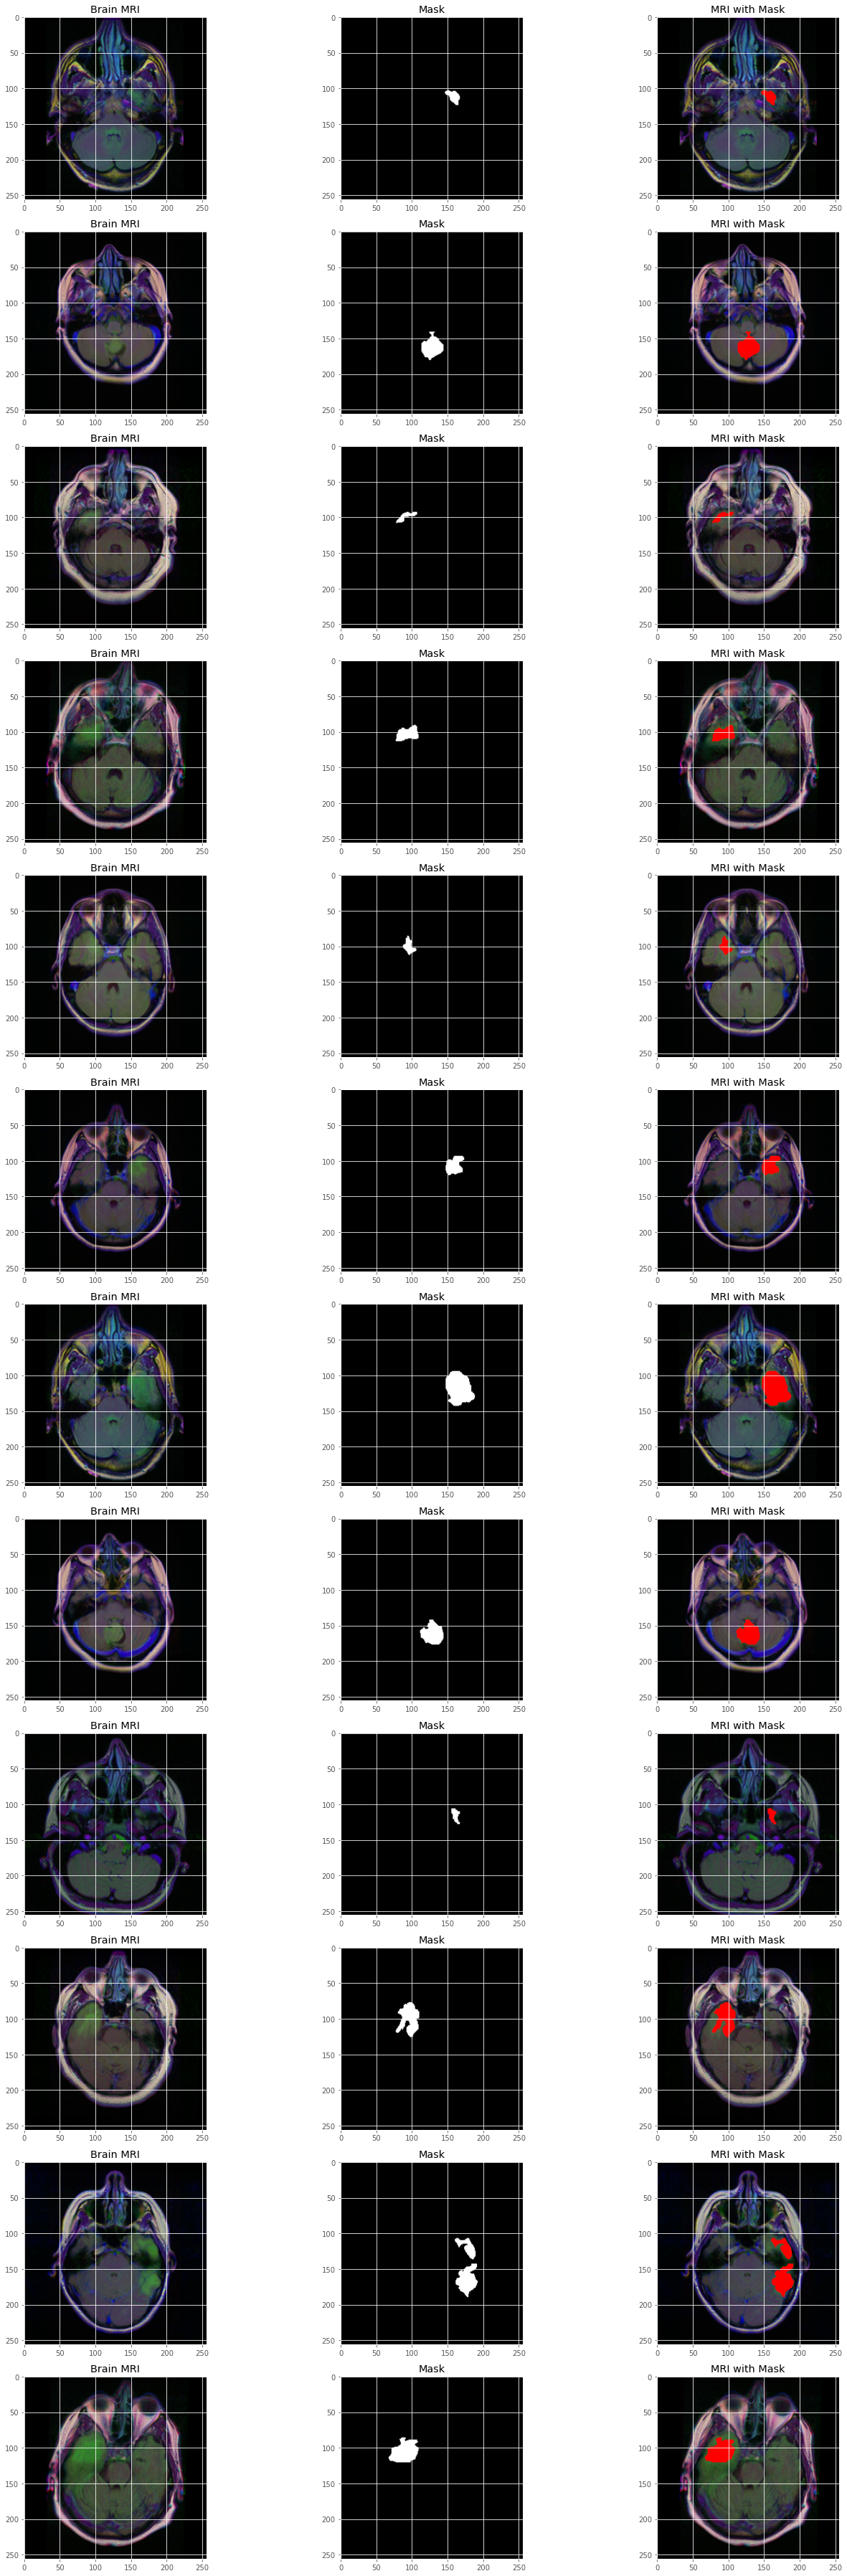

In [27]:

from skimage import io
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
    if brain_df['mask'][i] ==1 and count <12:
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text('Brain MRI')
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text('Mask')
        axs[count][1].imshow(mask, cmap = 'gray')


        img[mask == 255] = (255, 0, 0)
        axs[count][2].title.set_text('MRI with Mask')
        axs[count][2].imshow(img)
        count+=1

fig.tight_layout()

